# Exploratory analysis

This notebook is a collection of exploratory analyses, notes and visualizations collected while getting to know the data in the **Planet: Understanding the Amazon from Space** [Kaggle challenge](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

This is a fork of [this notebook](https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb) provided by Planet

In [2]:
import sys
import os
import math

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Setup
Set paths to image files and labels csv.

In [3]:
ROOT = os.path.abspath("./data/")
JPEG_DIR = os.path.join(ROOT, 'train-jpg')
TIF_DIR = os.path.join(ROOT, 'train-tif-v2')
LABEL_CSV = os.path.join(ROOT, 'train_v2.csv')
assert os.path.exists(ROOT)
assert os.path.exists(JPEG_DIR)
assert os.path.exists(TIF_DIR)
assert os.path.exists(LABEL_CSV)

## Inspect image labels
The labels are in a CSV entitled `labels.csv`. Note that each image can be tagged with multiple tags. We'll convert them to a "one hot" style representation where each label is a column:

In [27]:
labels_df = pd.read_csv(LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [29]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [30]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


Now, let's look at the labels' frequencies, and which ones cooccur. You'll notice that the classes are very uneven, e.g. the weather related tags are much more frequent than the land use tags, e.g. selective_logging)

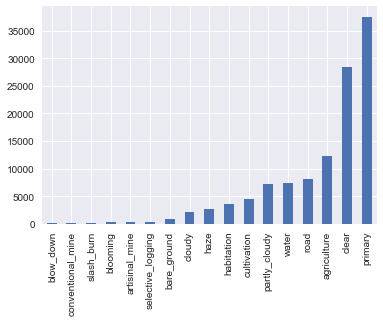

In [31]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


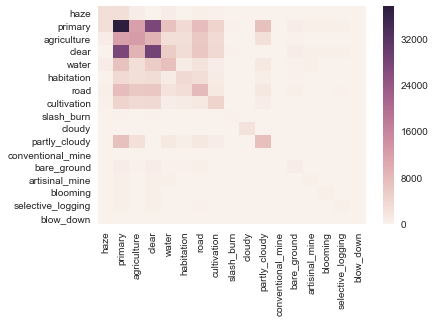

In [32]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


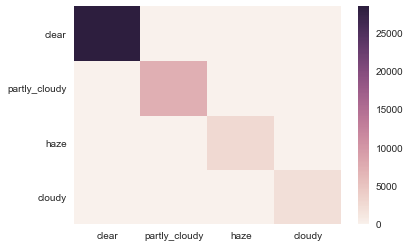

In [33]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


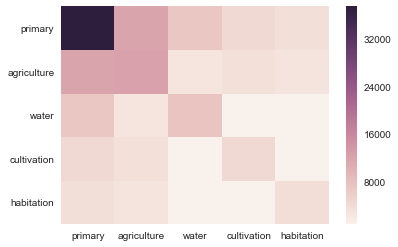

In [34]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


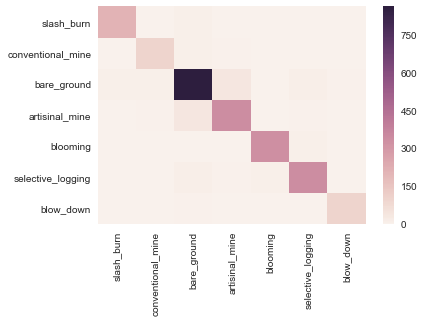

In [35]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

## Inspect images
Here we will define some useful functions for loading a random set of images and either loading the pixel data into a numpy array or diplaying the jpeg preview images.

### Conclusion
This is going to be difficult. I have difficulty distinguishing between many of the categories, particularly the less common labels

In [36]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [44]:
def load_tiff(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    for dirname in os.listdir(ROOT):
        path = os.path.abspath(os.path.join(ROOT, dirname, filename))
        if os.path.exists(path):
            with rasterio.open(path) as src:
                b, g, r, nir = src.read()
                return np.dstack([r, g, b, nir])

In [38]:
def sample_jpgs(tags, n=9):
    """Return file paths to a random set of n jpeg images with the specified tags"""
    names = sample_images(tags, n)['image_name'].values
    paths = [os.path.join(JPEG_DIR, name + '.jpg') for name in names]
    return paths 

In [39]:
def display_sample_jpgs(tags, n=9):
    """Display a grid of sample jpeg images"""
    paths = sample_jpgs(tags, n)
    
    grid_size = math.ceil(n**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, sharex=True, sharey=True)
    fig.set_size_inches(16, 16)
    
    for i, path in enumerate(paths):
        image = cv2.imread(path)
        axes.ravel()[i].imshow(image)
        axes.ravel()[i].grid(False)

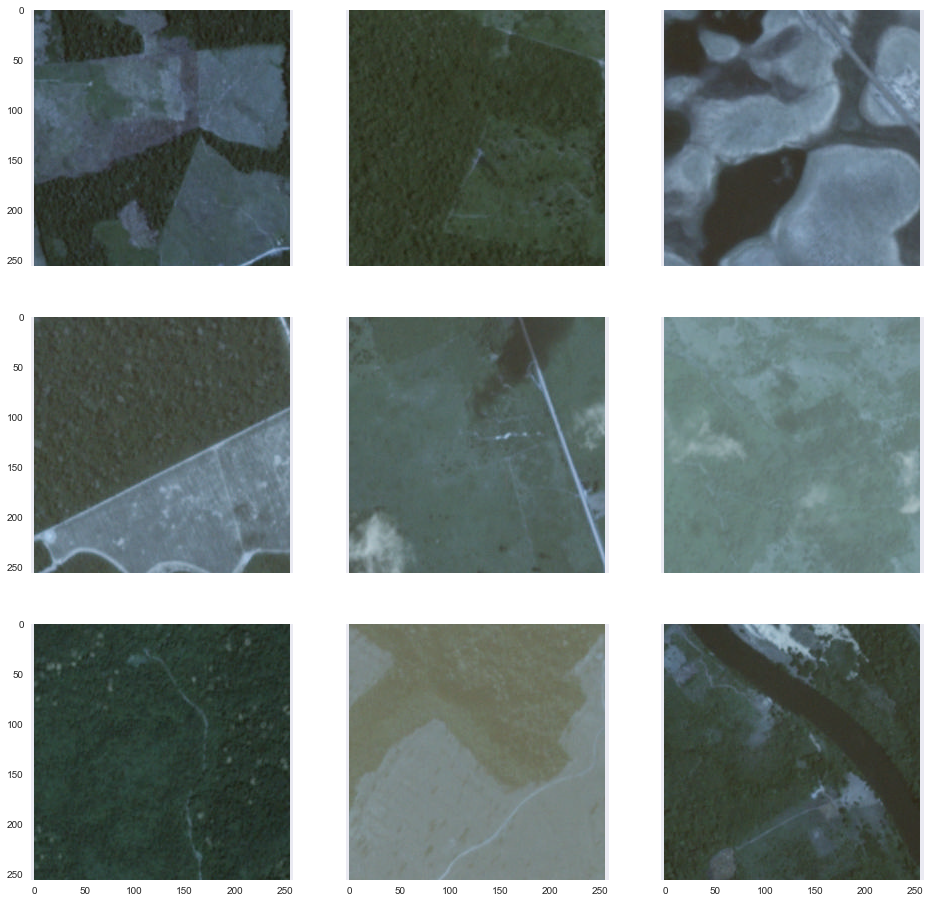

In [40]:
display_sample_jpgs(['road'], 9)

# Pixel values
To get more detail, we can inspect a histogram of pixel values in each r, g, b, nir channel from a particular image. In this case we will use the more complete tif image data.

/Users/misk6091/miniconda3/envs/amazon-classifier/lib/python3.6/site-packages/rasterio/__init__.py:282: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s.start()


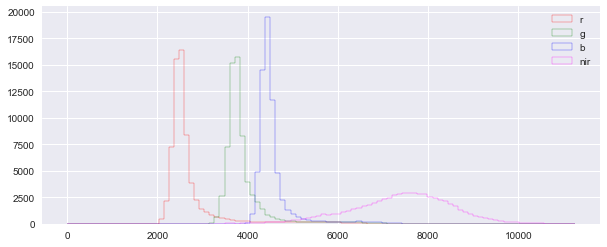

In [214]:
fig = plt.figure()
fig.set_size_inches(10, 4)
image_path = sample_images(['primary', 'water', 'road'], n=1)['image_name'].iloc[0]
rgbn_image = load_image(image_path + '.tif')
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]
for channel, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(channel.ravel(), bins=100, 
             range=[0,rgbn_image.max()], 
             label=name, color=color, histtype='step')
plt.legend()

## Histograms of R, G, B, NIR intensities

Unlike some problem domains, such as identifying cat pictures, where color has little or no correlation with the image content, it seems that some of the labels, particularly the weather labels, have some relationship with color. For example, "cloudy" images are relatively white, hazy images are low contrast, clear images are higher contrast, etc.

### Hypothesis #1: weather labels are correlated with basic image color characteristics

To investigate this hypothesis, we will visualize the **average** r,g,b,n histograms for a random sample of images from each label

### Conclusion

It seems to be true, that **on average** the different weather labels display charateristic color profiles. The only two that are quite similar are "haze" and "clear". Interestingly, the near infrared distribution looks identical between the different weather labels.

/Users/misk6091/miniconda3/envs/amazon-classifier/lib/python3.6/site-packages/rasterio/__init__.py:282: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s.start()


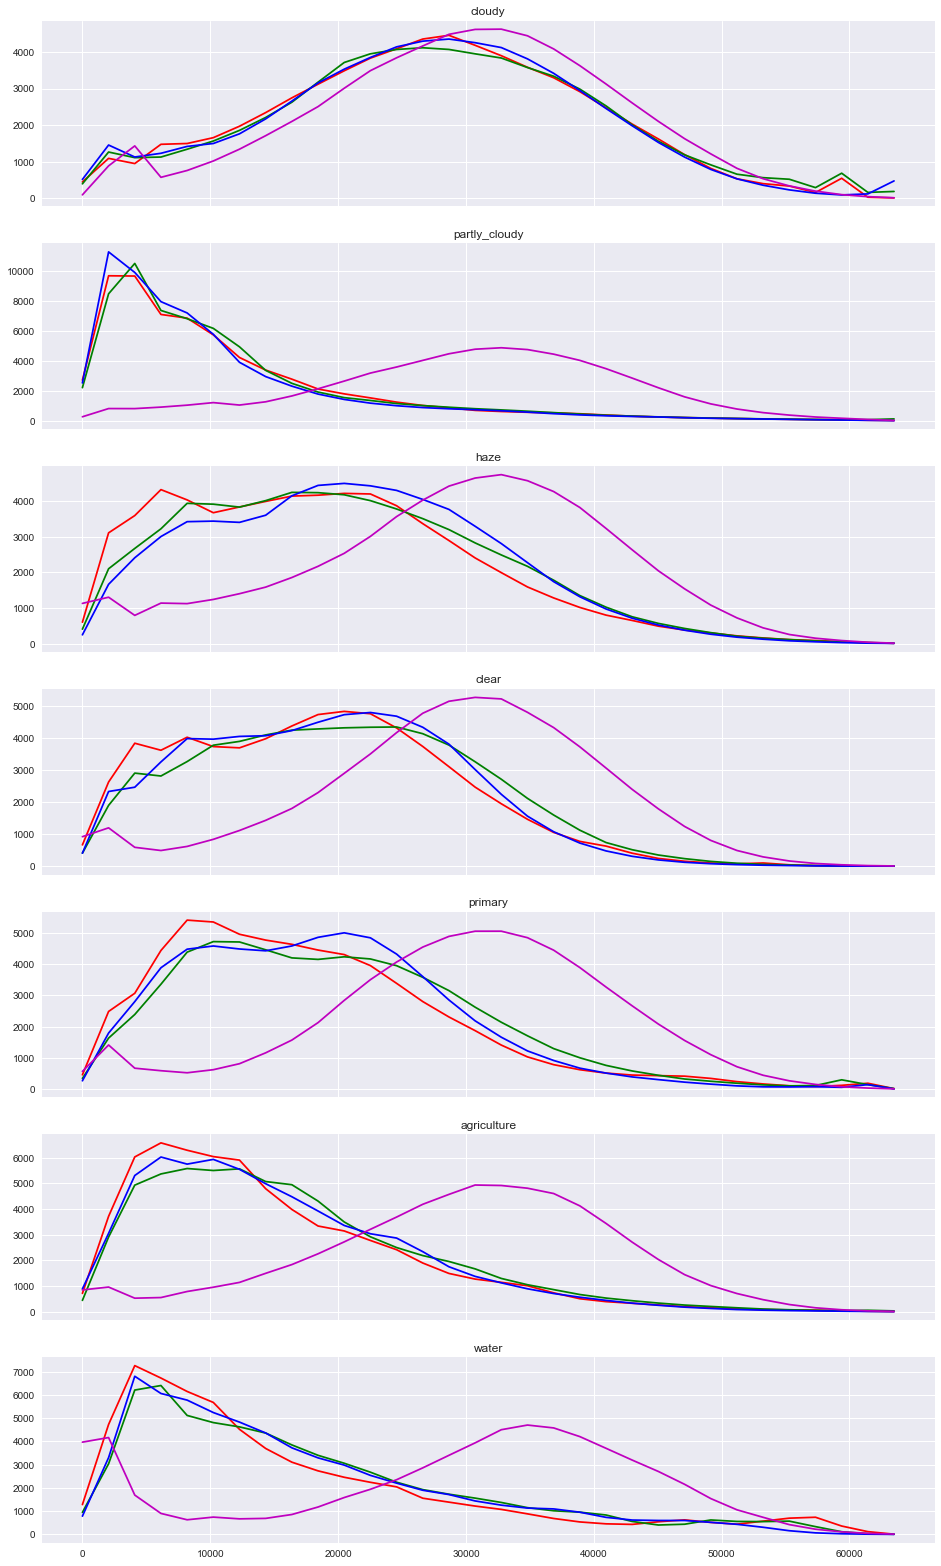

In [43]:
labels = ['cloudy', 'partly_cloudy', 'haze', 'clear', 'primary', 'agriculture', 'water']
sample_size = 100
dynamic_range = 2**16
bins = 32
bin_labels = [dynamic_range / bins * i for i in range(bins)]

fig, axes = plt.subplots(len(labels), 1, sharex=True)
fig.set_size_inches(16, 28)

for i, label in enumerate(labels):
    hists = np.zeros((bins, sample_size, 4))
    image_paths = sample_images([label], n=sample_size)['image_name']
    for index, path in enumerate(image_paths):
        image = load_tiff(path + '.tif')
        for channel, color in enumerate(['red', 'green', 'blue', 'magenta']):
            hists[:, index, channel], _ = np.histogram(image[:, :, channel], bins)
            #ax1.plot(bin_labels, hists[:, index, channel], color=color)

    average_histograms = hists.mean(axis=1)
    for channel, color in enumerate(['r', 'g', 'b', 'm']):
        axes[i].plot(bin_labels, average_histograms[:, channel], color=color)
        
    axes[i].set_title(label)

# Spatial correlations

Here we will investigate if there are spatial correlations that characterize different types of images. This type of information could also be captured by a trained convolutional neural network, but it could be faster and more easily interpretted if particular features appear in the frequency domain. One way to characterize the spatial correlations or patterns is the [power spectrum](https://en.wikipedia.org/wiki/Spectral_density), which is basically the square of the 2D fourier transform of the image, which is fast thanks to the Fast Fourier Transform.

### Hypothesis:

Some image labels could be classified based on simple spatial correlations in the image. For example, the `primary` category representing primary rain forest, seems to be characterized by a texture with spatial correlation on the length scale of a tree crown.

In [72]:
def radial_average(image, spectrum):
    L = max(image.shape)
    # get a list of frequencies up to half the image size
    freqs = np.fft.fftfreq(L)[:int(L/2)]
    # radial distances
    dists = np.sqrt(np.fft.fftfreq(image.shape[0])[:, np.newaxis]**2
                    + np.fft.fftfreq(image.shape[1])**2)
    dcount = np.histogram(dists.ravel(), bins=freqs)[0]
    hist, bins = np.histogram(dists.ravel(), bins=freqs, weights=spectrum.ravel())
    return (hist, bins)

def radially_averaged_power_spectrum(image):
    fft = np.fft.fft2(image)
    spectrum = np.real(np.abs(fft))**2
    (raps, bins) = radial_average(image, spectrum)
    return (raps, bins)

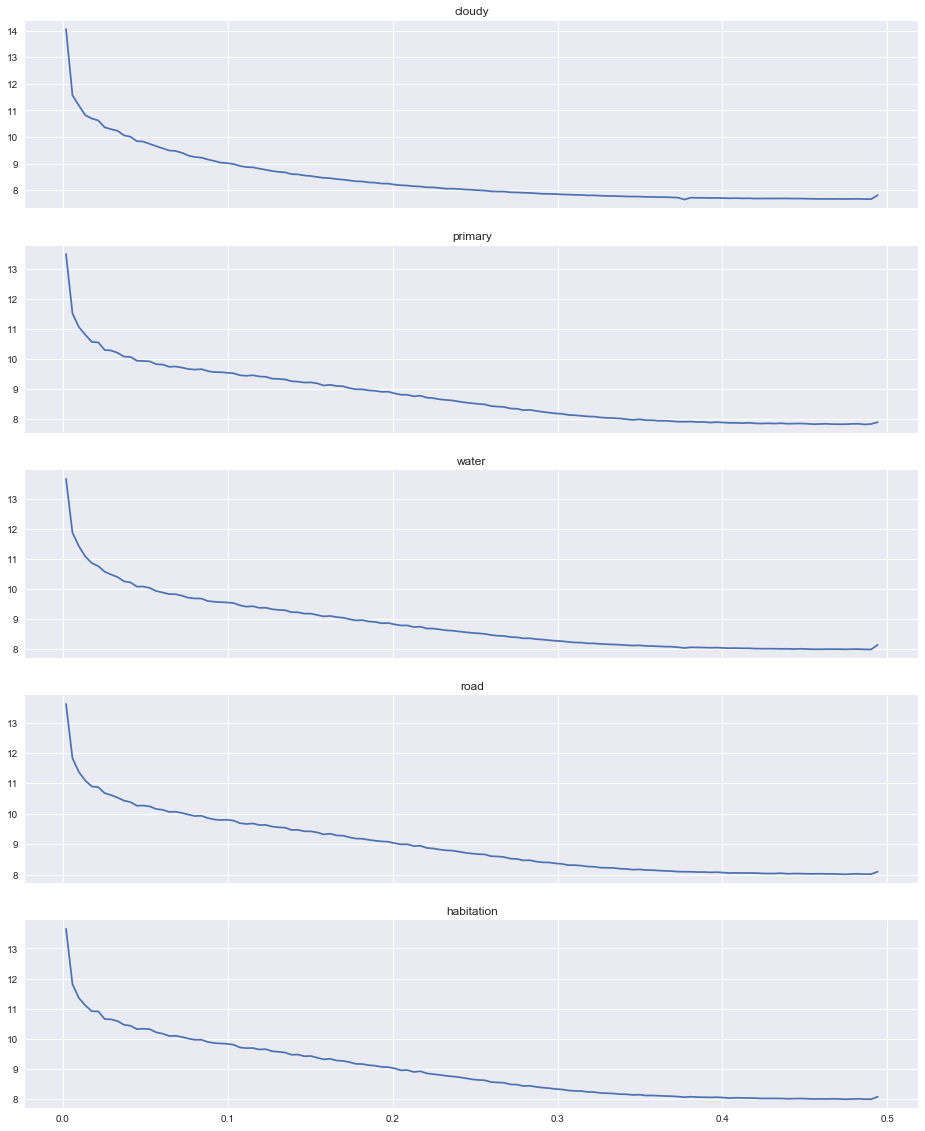

In [79]:
labels = ['cloudy', 'primary', 'water', 'road', 'habitation']
sample_size = 100

fig, axes = plt.subplots(len(labels), 1, sharex=True)
fig.set_size_inches(16, 4 * len(labels))

for i, label in enumerate(labels):
    # load spectrums into a dictionary because we don't know what their shape is going to be
    power_spectrums = {}
    image_paths = sample_jpgs([label], n=sample_size)
    for index, path in enumerate(image_paths):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        power_spectrums[index], bins = radially_averaged_power_spectrum(image)

    # now put all the spectrums into a numpy array
    ps_array = np.asarray([ps for key, ps in power_spectrums.items()])
    average_power_spectrum = ps_array.mean(axis=0)
    
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axes[i].plot(bin_centers, np.log10(average_power_spectrum))    
    axes[i].set_title(label)